
# Visual Toy Examples for kNN, IVF, and HNSW (2D)

This notebook creates **2D point plots** to build intuition for:
- Exact **kNN** (baseline)
- **IVF** (Inverted File index) with coarse centroids and list probing
- **HNSW** (Hierarchical Navigable Small World) with layered graphs and **greedy search path**

**Plot rules**: separate figures (no subplots), use only `matplotlib`, and do not set explicit colors.


In [1]:

import math
import random
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
random.seed(42)
plt.rcParams['figure.dpi'] = 120



## 1) Generate Clustered 2D Data


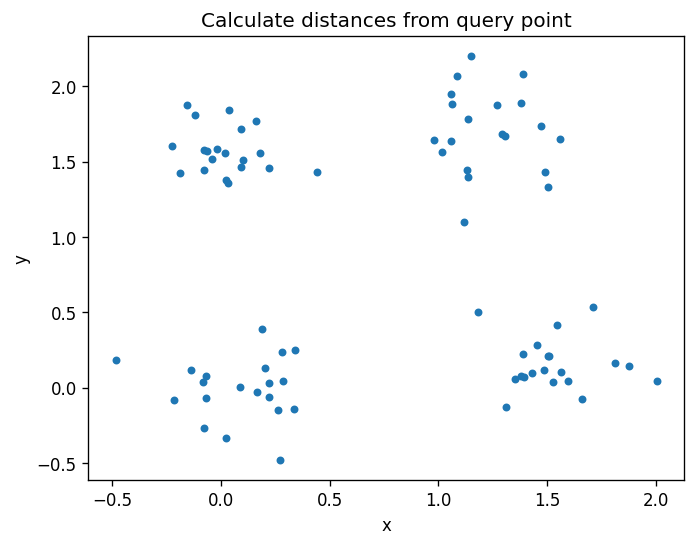

In [48]:

def make_clusters(centers, n_per=10, spread=0.25, seed=42):
    rng = np.random.default_rng(seed)
    points = []
    labels = []
    for i, (cx, cy) in enumerate(centers):
        pts = rng.normal(loc=(cx, cy), scale=spread, size=(n_per, 2))
        points.append(pts)
        labels.extend([i]*n_per)
    X = np.vstack(points)
    labels = np.array(labels)
    return X, labels

centers = [(0,0), (1.5, 0.2), (1.2, 1.7), (0.0, 1.5)]
X, y = make_clusters(centers, n_per=20, spread=0.22, seed=123)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=14)
plt.title("Calculate distances from query point")
# plt.title("2D Clustered Dataset")
plt.xlabel("x"); plt.ylabel("y")
plt.show()



## 2) Exact kNN (Baseline)


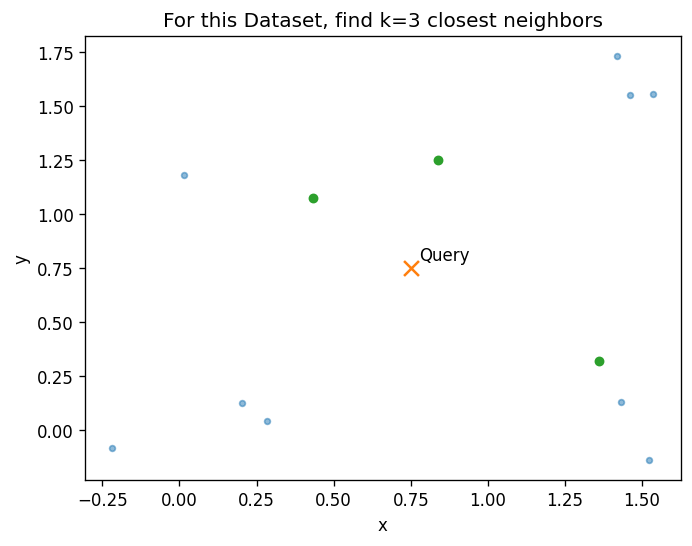

In [42]:
def knn_indices(X, q, k=5):
    dists = np.linalg.norm(X - q, axis=1)
    idxs = np.argpartition(dists, k-1)[:k]
    idxs = idxs[np.argsort(dists[idxs])]
    return idxs, dists

q = np.array([.75, .75])
k = 3
idxs, dists = knn_indices(X, q, k=3)
# label the query point when showing the figure (one-time patch)
orig_show = plt.show
def _show_with_query_label(*args, **kwargs):
    ax = plt.gca()
    # for idx in range(len(X)):
    #     ax.annotate(str(idx), xy=(X[idx,0], X[idx,1]), xytext=(3, 3), textcoords="offset points", fontsize=8)
    ax.annotate("Query", xy=(q[0], q[1]), xytext=(5, 5), textcoords="offset points")
    plt.show = orig_show  # restore original show
    return orig_show(*args, **kwargs)
plt.show = _show_with_query_label

plt.figure()
plt.scatter(X[:,0], X[:,1], s=12, alpha=0.5)
plt.scatter([q[0]], [q[1]], marker="x", s=80)
plt.scatter(X[idxs,0], X[idxs,1], s=24)
# for i in idxs:
#     plt.plot([q[0], X[i,0]], [q[1], X[i,1]], linewidth=0.8)
plt.title(f"kNN Example (k={k})")
plt.title("For this Dataset, find k=3 closest neighbors")
# plt.title("Calculate distances to every point to query point")

# plt.title("Select the k points with smallest distances")

plt.xlabel("x"); plt.ylabel("y")
plt.show()


In [37]:
import pandas as pd
df=pd.DataFrame(list(zip(idxs, dists)), columns=['Point','Distance'])
df.head(20)  



,Point,Distance
0,9,1.275413
1,11,0.847395
2,3,0.829449
3,2,0.746751
4,1,0.921099
5,10,1.174519
6,4,1.072903
7,6,1.187165
8,8,1.125681
9,5,0.454620


In [38]:
#sort by point
df_sorted = df.sort_values(by='Distance')
df_sorted.head(20)

,Point,Distance
9,5,0.454620
11,0,0.505817
3,2,0.746751
2,3,0.829449
1,11,0.847395
10,7,0.853182
4,1,0.921099
6,4,1.072903
8,8,1.125681
5,10,1.174519



## 3) Minimal k-means (for IVF Centroids)


RecursionError: maximum recursion depth exceeded while calling a Python object

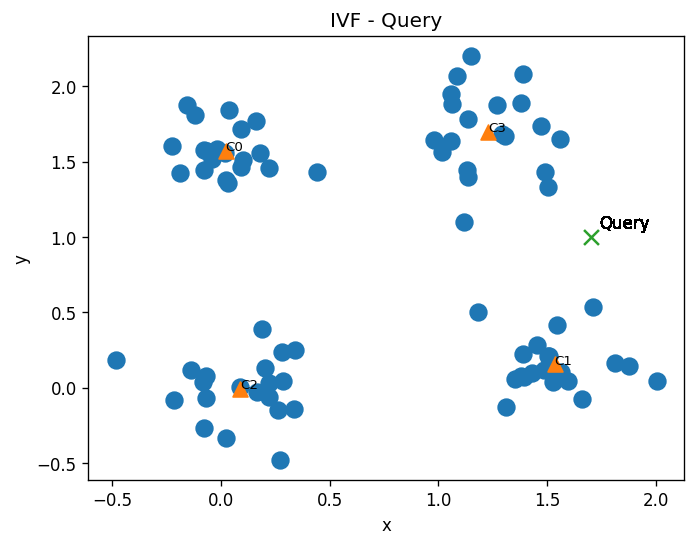

In [110]:

def kmeans(X, n_clusters=6, iters=2, seed=0):
    rng = np.random.default_rng(seed)
    init_idx = rng.choice(len(X), size=n_clusters, replace=False)
    C = X[init_idx].copy()
    for _ in range(iters):
        d2 = ((X[:,None,:] - C[None,:,:])**2).sum(axis=2)
        labels = d2.argmin(axis=1)
        newC = np.zeros_like(C)
        for k in range(n_clusters):
            pts = X[labels == k]
            if len(pts) > 0:
                newC[k] = pts.mean(axis=0)
            else:
                newC[k] = X[rng.integers(0, len(X))]
        if np.allclose(newC, C):
            C = newC
            break
        C = newC
    return C, labels

nlist = 4
C, list_labels = kmeans(X, n_clusters=nlist, iters=20, seed=7)
q_ivf = np.array([1.7, 1.0])
plt.figure()
plt.scatter(X[:,0], X[:,1], s=100)
plt.scatter(C[:,0], C[:,1], marker="^", s=80)
for i,c in enumerate(C):
    plt.text(c[0], c[1], "C"+str(i), fontsize=8)
plt.scatter(q_ivf[0], q_ivf[1], marker="x", s=80)
plt.annotate("Query", xy=(q_ivf[0], q_ivf[1]), xytext=(5, 5), textcoords="offset points")
plt.title(f"IVF - Centroids (nlist={nlist})")
plt.title(f"IVF - Raw Data")
plt.title(f"IVF - Build Clusters (n={nlist})")
plt.title(f"IVF - Query")
plt.xlabel("x"); plt.ylabel("y")
plt.show()



## 4) IVF Probing Demo


RecursionError: maximum recursion depth exceeded while calling a Python object

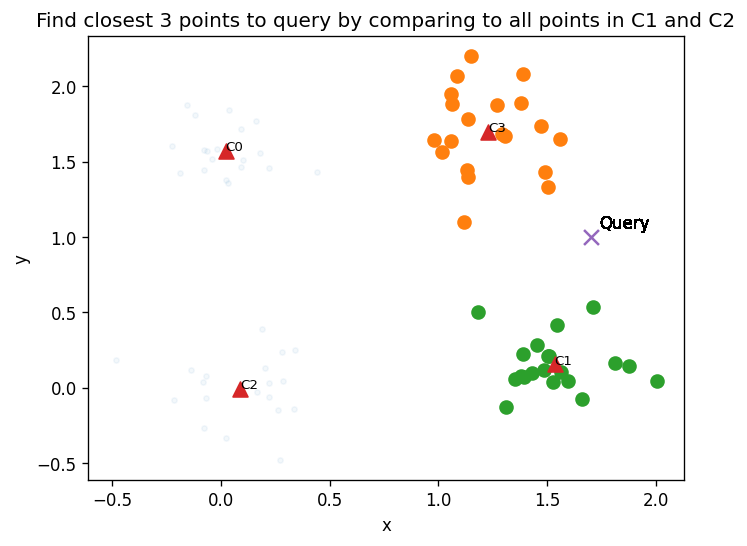

In [111]:

def ivf_probe_lists(C, q, nprobe=2):
    d2 = ((C - q)**2).sum(axis=1)
    order = np.argsort(d2)
    return order[:nprobe], order

q_ivf = np.array([1.7, 1.0])
nprobe = 2
probe, order = ivf_probe_lists(C, q_ivf, nprobe=nprobe)

# for c in C:
#     plt.plot([q_ivf[0], c[0]], [q_ivf[1], c[1]], linestyle='--', linewidth=1)
def _show_with_q_ivf_label(*args, **kwargs):
    ax = plt.gca()
    ax.annotate("Query", xy=(q_ivf[0], q_ivf[1]), xytext=(5, 5), textcoords="offset points")
    plt.show = orig_show_ivf
    return orig_show_ivf(*args, **kwargs)
plt.show = _show_with_q_ivf_label
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.05)
for li in probe:
    mask = (list_labels == li)
    plt.scatter(X[mask,0], X[mask,1], s=60)
plt.scatter(C[:,0], C[:,1], marker="^", s=80)
for i,c in enumerate(C):
    plt.text(c[0], c[1], "C"+str(i), fontsize=8)
plt.scatter([q_ivf[0]], [q_ivf[1]], marker="x", s=80)
plt.title(f"Find closest 3 points to query by comparing to all points in C1 and C2")
plt.xlabel("x"); plt.ylabel("y")
plt.show()



## 5) Toy HNSW Builder (Simplified)


In [6]:

import random

def geometric_level(p=0.5):
    L = 0
    while random.random() < p:
        L += 1
    return L

def build_toy_hnsw(X, M=4, p=0.5, seed=0):
    random.seed(seed)
    N = len(X)
    levels = [geometric_level(p) for _ in range(N)]
    max_level = max(levels)
    graph = [ {l: set() for l in range(max_level+1)} for _ in range(N) ]
    order = list(range(N))
    for i in order:
        Li = levels[i]
        for l in range(Li, -1, -1):
            cand = [j for j in range(i) if levels[j] >= l]
            if len(cand) == 0:
                continue
            d = np.linalg.norm(X[cand] - X[i], axis=1)
            chosen = np.array(cand)[np.argsort(d)[:M]]
            for j in chosen:
                graph[i][l].add(int(j))
                graph[j][l].add(int(i))
    entry_point = int(np.argmax(levels))
    return graph, levels, entry_point

graph, levels, entry = build_toy_hnsw(X, M=4, p=0.5, seed=0)
max_level = max(levels)

from collections import Counter
Counter(levels), entry, max_level


(Counter({0: 225, 1: 126, 2: 68, 3: 30, 4: 18, 5: 7, 6: 4, 8: 1, 7: 1}),
 277,
 8)


## 6) Visualize HNSW Layers


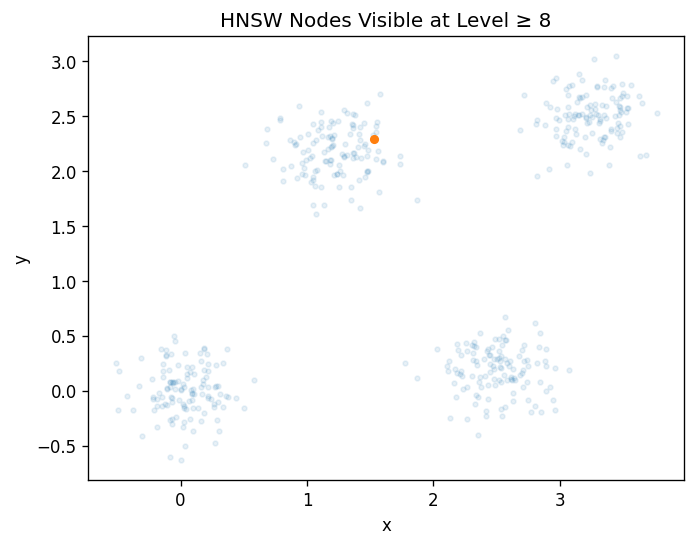

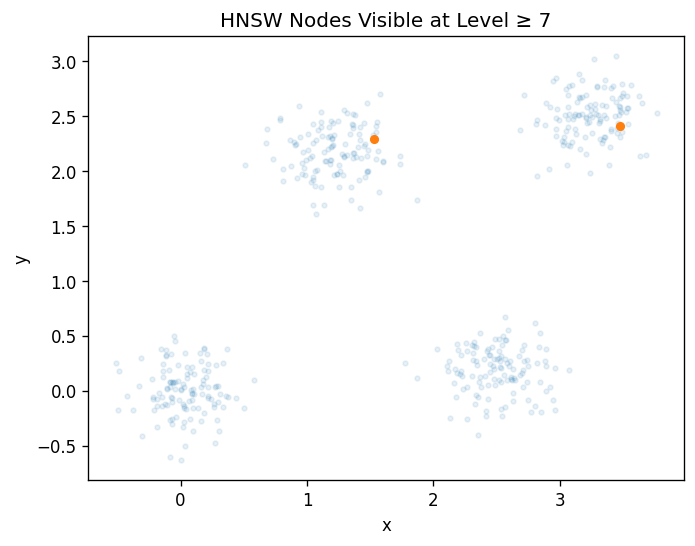

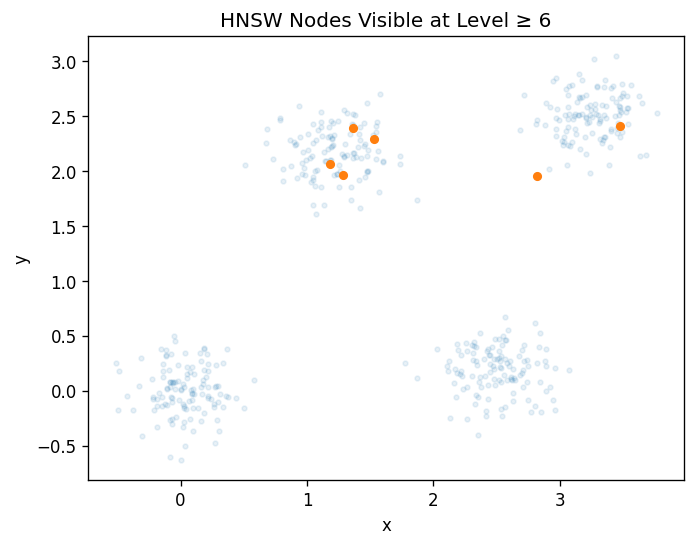

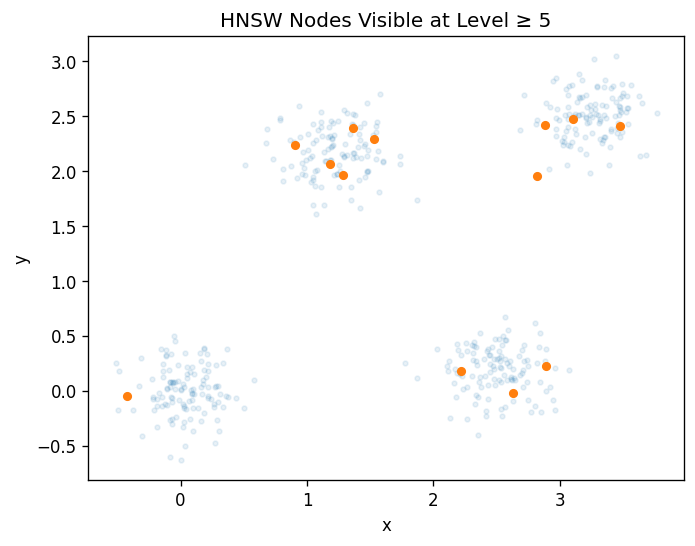

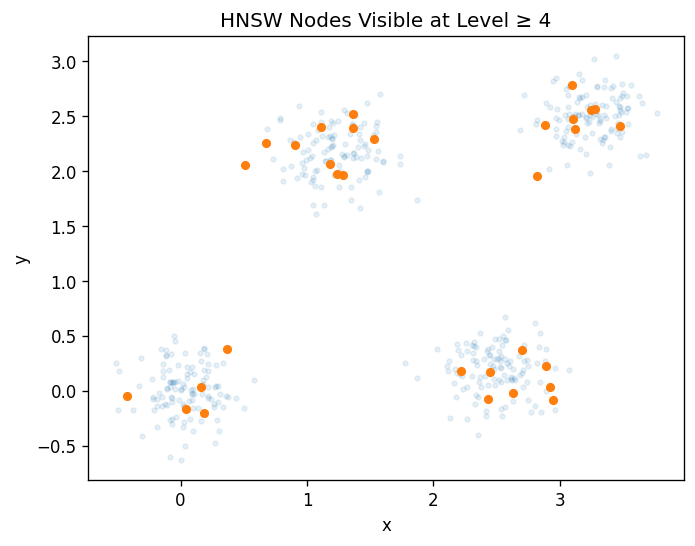

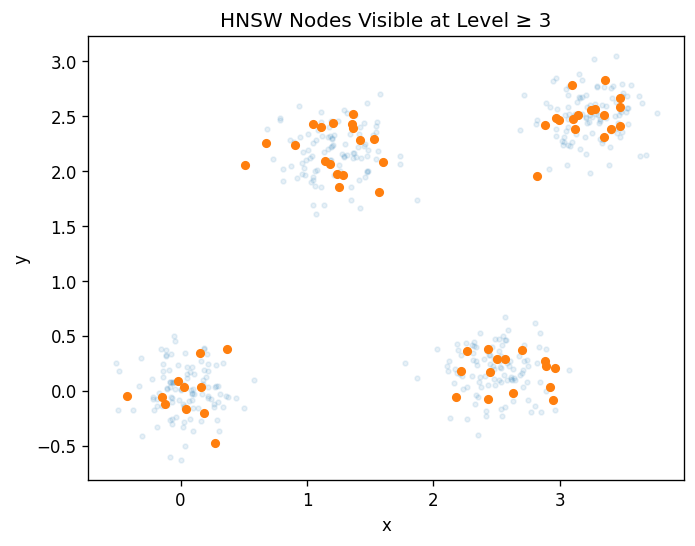

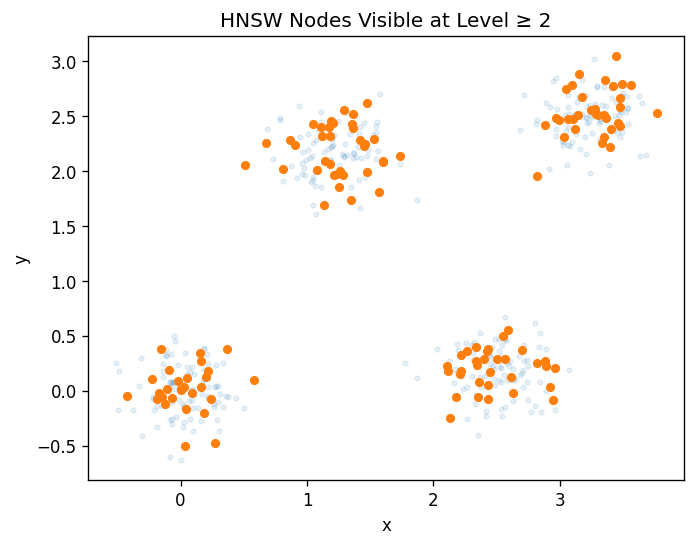

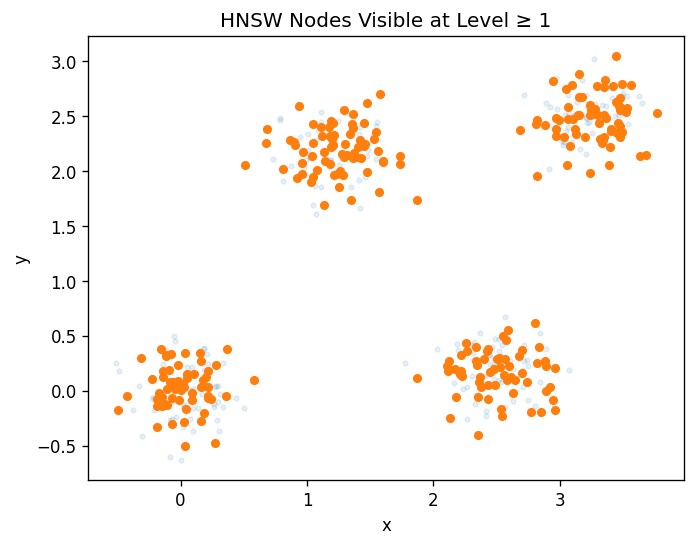

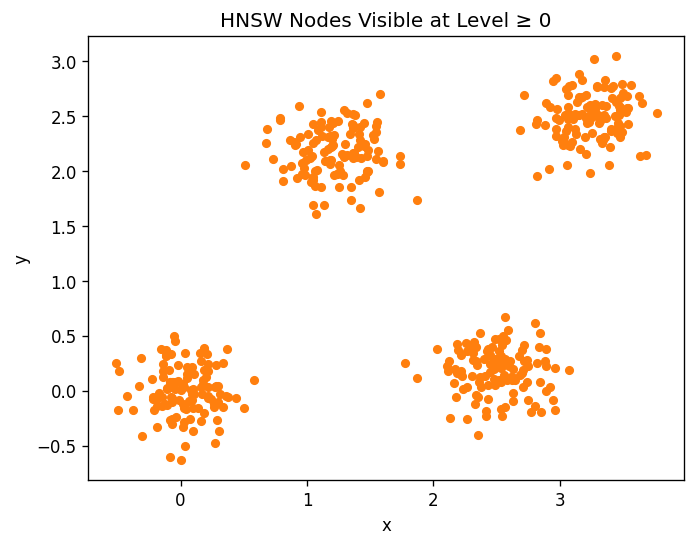

In [7]:

for l in range(max_level, -1, -1):
    mask = np.array([lvl >= l for lvl in levels])
    plt.figure()
    plt.scatter(X[~mask,0], X[~mask,1], s=8, alpha=0.1)
    plt.scatter(X[mask,0], X[mask,1], s=20)
    plt.title(f"HNSW Nodes Visible at Level ≥ {l}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()



## 7) Greedy Search Path (Top-down)


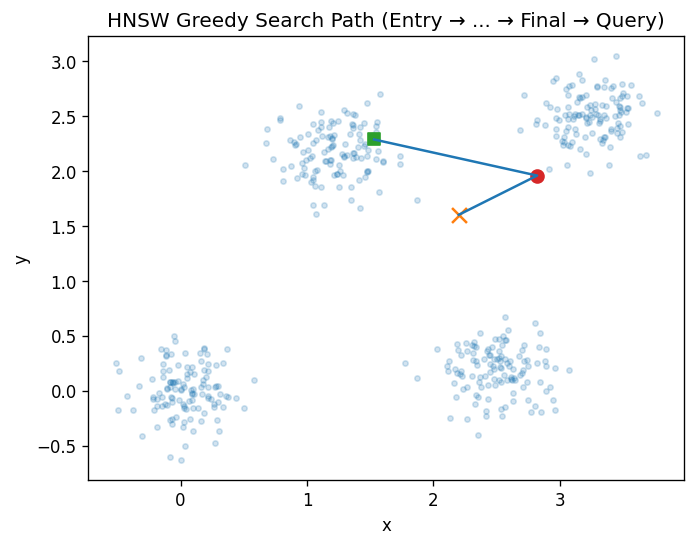

(458, [277, 277, 277, 458, 458, 458, 458, 458, 458, 458])

In [8]:

def greedy_search_path(X, graph, levels, entry, q, start_level=None):
    if start_level is None:
        start_level = max(levels)
    path_points = []
    curr = entry
    for l in range(start_level, -1, -1):
        improved = True
        while improved:
            improved = False
            path_points.append(curr)
            curr_dist = np.linalg.norm(X[curr] - q)
            nbrs = list(graph[curr][l])
            best = curr
            best_dist = curr_dist
            for nb in nbrs:
                d = np.linalg.norm(X[nb] - q)
                if d < best_dist:
                    best = nb
                    best_dist = d
            if best != curr:
                curr = best
                improved = True
    return path_points, curr

q_hnsw = np.array([2.2, 1.6])
path, final_idx = greedy_search_path(X, graph, levels, entry, q_hnsw, start_level=max(levels))

plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.2)
plt.scatter([q_hnsw[0]], [q_hnsw[1]], marker="x", s=80)
xs = [X[i,0] for i in path] + [q_hnsw[0]]
ys = [X[i,1] for i in path] + [q_hnsw[1]]
plt.plot(xs, ys, linewidth=1.5)
plt.scatter([X[entry,0]], [X[entry,1]], marker="s", s=60)
plt.scatter([X[final_idx,0]], [X[final_idx,1]], marker="o", s=60)
plt.title("HNSW Greedy Search Path (Entry → ... → Final → Query)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

final_idx, path[:10]



## 8) Compare to Exact kNN (Optional)


In [9]:

def knn_indices(X, q, k=10):
    dists = np.linalg.norm(X - q, axis=1)
    idxs = np.argpartition(dists, k)[:k]
    idxs = idxs[np.argsort(dists[idxs])]
    return idxs, dists

kcheck = 10
idxs, dists = knn_indices(X, q_hnsw, k=kcheck)
print("Final node index:", final_idx)
print("Among top-{} exact neighbors?".format(kcheck), bool((final_idx in idxs)))
print("Exact top-{} indices:".format(kcheck), idxs)


Final node index: 458
Among top-10 exact neighbors? True
Exact top-10 indices: [340 349 288 307 458 290 246 312 258 415]
